# 🔬 Comprehensive Model Calibration & Evaluation

## School Suspension Prediction - Probability Calibration Study

**Objective**: Systematically evaluate and improve probability calibration while preserving model discrimination.

**Critical Requirements**:
- ✅ Improve calibration (ECE < 0.10)
- ✅ **Preserve discrimination** (separation ≥ 25%)
- ✅ Maintain recall performance (F2 ≥ 0.55)
- ✅ Account for class imbalance (2.13% positive rate)

**Key Insight**: *Calibration without discrimination is useless. A model that predicts 50% for everything is perfectly calibrated but worthless for decision-making.*

---

## Table of Contents

1. **Setup & Baseline Assessment** - Current model performance
2. **Calibration Diagnostics** - Why current probabilities are miscalibrated  
3. **Scenario Testing** - Model behavior across weather conditions
4. **Calibration Methods** - Test 6 different approaches
5. **Comprehensive Evaluation** - Multi-metric comparison
6. **Historical Validation** - Test on real suspension events
7. **Final Recommendations** - Production-ready solution

---
## 📦 Section 1: Setup & Baseline Assessment

In [55]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from pathlib import Path
from datetime import date
import warnings
warnings.filterwarnings('ignore')

# ML metrics
from sklearn.metrics import (
    confusion_matrix, classification_report,
    precision_score, recall_score, f1_score, fbeta_score,
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    brier_score_loss, log_loss
)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

# Setup paths
DATA_DIR = Path('../data')
PROCESSED_DIR = DATA_DIR / 'processed'
RESULTS_DIR = PROCESSED_DIR / 'calibration_results'
RESULTS_DIR.mkdir(exist_ok=True)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Setup complete")
print(f"   Results will be saved to: {RESULTS_DIR}")

✅ Setup complete
   Results will be saved to: ..\data\processed\calibration_results


In [56]:
# Load model and data
print("="*80)
print("LOADING MODEL & DATA")
print("="*80)

# Load best model
model = joblib.load(PROCESSED_DIR / 'best_core_model.pkl')
print(f"\n✅ Model loaded: {type(model).__name__}")

# Load metadata
with open(PROCESSED_DIR / 'core_model_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"\n📊 Model Performance (Validation Set):")
print(f"   • F2 Score:  {metadata['best_f2']:.4f}")
print(f"   • Recall:    {metadata['best_recall']:.4f}")
print(f"   • Precision: {metadata['best_precision']:.4f}")
print(f"   • Features:  {metadata['final_feature_count']}")

# Load training data for calibration
train_df = pd.read_csv(PROCESSED_DIR / 'master_train.csv')
val_df = pd.read_csv(PROCESSED_DIR / 'master_validation.csv')
test_df = pd.read_csv(PROCESSED_DIR / 'master_test.csv')

print(f"\n📦 Data Loaded:")
print(f"   • Training:   {len(train_df):,} samples ({train_df['suspension_occurred'].sum()} suspensions, {train_df['suspension_occurred'].mean():.2%})")
print(f"   • Validation: {len(val_df):,} samples ({val_df['suspension_occurred'].sum()} suspensions, {val_df['suspension_occurred'].mean():.2%})")
print(f"   • Test:       {len(test_df):,} samples ({test_df['suspension_occurred'].sum()} suspensions, {test_df['suspension_occurred'].mean():.2%})")

print(f"\n⚠️  Class Imbalance: {(1 - train_df['suspension_occurred'].mean()) / train_df['suspension_occurred'].mean():.1f}:1 ratio")
print("="*80)

LOADING MODEL & DATA

✅ Model loaded: EasyEnsembleClassifier

📊 Model Performance (Validation Set):
   • F2 Score:  0.5525
   • Recall:    0.6020
   • Precision: 0.4158
   • Features:  33

📦 Data Loaded:
   • Training:   11,033 samples (110 suspensions, 1.00%)
   • Validation: 3,111 samples (201 suspensions, 6.46%)
   • Test:       4,556 samples (134 suspensions, 2.94%)

⚠️  Class Imbalance: 99.3:1 ratio


In [57]:
# Generate predictions for calibration analysis
print("\n🔮 Generating predictions...")

# Feature order (from metadata)
FEATURE_ORDER = metadata['selected_features']

# Training predictions (for calibration fitting)
X_train = train_df[FEATURE_ORDER]
y_train = train_df['suspension_occurred']
train_probs = model.predict_proba(X_train)[:, 1]
train_preds = (train_probs >= 0.5).astype(int)

# Validation predictions (for calibration evaluation)
X_val = val_df[FEATURE_ORDER]
y_val = val_df['suspension_occurred']
val_probs = model.predict_proba(X_val)[:, 1]
val_preds = (val_probs >= 0.5).astype(int)

# Test predictions (for final holdout evaluation)
X_test = test_df[FEATURE_ORDER]
y_test = test_df['suspension_occurred']
test_probs = model.predict_proba(X_test)[:, 1]
test_preds = (test_probs >= 0.5).astype(int)

print(f"✅ Predictions generated for all sets")
print(f"   • Training:   {len(train_probs):,} probabilities")
print(f"   • Validation: {len(val_probs):,} probabilities")
print(f"   • Test:       {len(test_probs):,} probabilities")


🔮 Generating predictions...
✅ Predictions generated for all sets
   • Training:   11,033 probabilities
   • Validation: 3,111 probabilities
   • Test:       4,556 probabilities


In [58]:
# Define comprehensive evaluation metrics
def compute_comprehensive_metrics(y_true, y_pred, y_proba, set_name=""):
    """
    Compute all metrics needed for calibration evaluation.
    
    Critical metrics for imbalanced classification:
    - Calibration: ECE, Brier Score, Log Loss
    - Discrimination: Class Separation, Sharpness, PR-AUC
    - Performance: Recall, Precision, F2
    """
    # Classification metrics
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    recall = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    f2 = fbeta_score(y_true, y_pred, beta=2, zero_division=0)
    
    # Probabilistic metrics
    roc_auc = roc_auc_score(y_true, y_proba)
    pr_auc = average_precision_score(y_true, y_proba)
    brier = brier_score_loss(y_true, y_proba)
    logloss = log_loss(y_true, y_proba)
    
    # Calibration metrics
    # Expected Calibration Error (ECE)
    n_bins = 10
    bin_edges = np.linspace(0, 1, n_bins + 1)
    bin_indices = np.digitize(y_proba, bin_edges[:-1]) - 1
    bin_indices = np.clip(bin_indices, 0, n_bins - 1)
    
    ece = 0
    for i in range(n_bins):
        mask = bin_indices == i
        if mask.sum() > 0:
            bin_acc = y_true[mask].mean()
            bin_conf = y_proba[mask].mean()
            bin_weight = mask.sum() / len(y_proba)
            ece += bin_weight * abs(bin_acc - bin_conf)
    
    # Class separation (critical for usability)
    suspended_probs = y_proba[y_true == 1]
    no_susp_probs = y_proba[y_true == 0]
    
    if len(suspended_probs) > 0 and len(no_susp_probs) > 0:
        separation = suspended_probs.mean() - no_susp_probs.mean()
        suspended_mean = suspended_probs.mean()
        no_susp_mean = no_susp_probs.mean()
    else:
        separation = 0
        suspended_mean = 0
        no_susp_mean = 0
    
    # Sharpness (spread of probabilities)
    sharpness_std = y_proba.std()
    sharpness_range = y_proba.max() - y_proba.min()
    
    metrics = {
        'set_name': set_name,
        # Classification
        'TP': int(tp), 'TN': int(tn), 'FP': int(fp), 'FN': int(fn),
        'Recall': recall,
        'Precision': precision,
        'F1': f1,
        'F2': f2,
        # Probabilistic
        'ROC_AUC': roc_auc,
        'PR_AUC': pr_auc,
        'Brier_Score': brier,
        'Log_Loss': logloss,
        # Calibration
        'ECE': ece,
        # Discrimination
        'Separation': separation,
        'Suspended_Mean': suspended_mean,
        'No_Susp_Mean': no_susp_mean,
        'Sharpness_Std': sharpness_std,
        'Sharpness_Range': sharpness_range,
        'Prob_Min': y_proba.min(),
        'Prob_Max': y_proba.max(),
    }
    
    return metrics

print("✅ Evaluation functions defined")

✅ Evaluation functions defined


In [59]:
# Compute baseline metrics
print("="*80)
print("BASELINE MODEL EVALUATION (UNCALIBRATED)")
print("="*80)

baseline_metrics = {}
for set_name, y_true, y_pred, y_proba in [
    ('Training', y_train, train_preds, train_probs),
    ('Validation', y_val, val_preds, val_probs),
    ('Test', y_test, test_preds, test_probs)
]:
    metrics = compute_comprehensive_metrics(y_true, y_pred, y_proba, set_name)
    baseline_metrics[set_name] = metrics
    
    print(f"\n{'='*80}")
    print(f"{set_name} Set Performance")
    print(f"{'='*80}")
    
    print(f"\n📊 Classification Metrics:")
    print(f"   • Recall:     {metrics['Recall']:.4f}  {'✅' if metrics['Recall'] >= 0.60 else '⚠️'}")
    print(f"   • Precision:  {metrics['Precision']:.4f}")
    print(f"   • F2 Score:   {metrics['F2']:.4f}  {'✅' if metrics['F2'] >= 0.55 else '⚠️'}")
    
    print(f"\n🎯 Calibration Metrics:")
    print(f"   • ECE:         {metrics['ECE']:.4f}  {'✅' if metrics['ECE'] < 0.05 else '⚠️' if metrics['ECE'] < 0.10 else '🚨'}")
    print(f"   • Brier Score: {metrics['Brier_Score']:.4f}  (lower is better)")
    
    print(f"\n🔍 Discrimination Metrics (CRITICAL):")
    print(f"   • Separation:       {metrics['Separation']:.4f} ({metrics['Separation']*100:.1f}%)  {'✅' if metrics['Separation'] >= 0.25 else '🚨'}")
    print(f"   • Suspended Mean:   {metrics['Suspended_Mean']:.4f} ({metrics['Suspended_Mean']*100:.1f}%)")
    print(f"   • No-Susp Mean:     {metrics['No_Susp_Mean']:.4f} ({metrics['No_Susp_Mean']*100:.1f}%)")
    print(f"   • Sharpness (Std):  {metrics['Sharpness_Std']:.4f}  {'✅' if metrics['Sharpness_Std'] >= 0.06 else '🚨'}")
    print(f"   • Range:            {metrics['Prob_Min']:.4f} - {metrics['Prob_Max']:.4f} ({metrics['Sharpness_Range']:.4f})")
    
    print(f"\n📈 Ranking Metrics:")
    print(f"   • ROC-AUC: {metrics['ROC_AUC']:.4f}")
    print(f"   • PR-AUC:  {metrics['PR_AUC']:.4f}  (baseline: {y_true.mean():.4f})")

print(f"\n{'='*80}")
print("💡 KEY FINDINGS")
print(f"{'='*80}")

test_metrics = baseline_metrics['Test']
print(f"\n✅ STRENGTHS:")
print(f"   • Strong recall: {test_metrics['Recall']:.1%} of suspensions detected")
print(f"   • Good separation: {test_metrics['Separation']:.1%} between classes")
print(f"   • Decent discrimination: {test_metrics['Sharpness_Std']:.4f} std dev")

print(f"\n🚨 PROBLEMS:")
print(f"   • Poor calibration: ECE = {test_metrics['ECE']:.4f} (should be <0.10)")
print(f"   • Overconfident: Predicts {test_metrics['Suspended_Mean']:.1%} for suspended cases")
print(f"   • But actual rate is only {y_test.mean():.1%}")
print(f"   • Systematic bias from class imbalance")

print("\n" + "="*80)

BASELINE MODEL EVALUATION (UNCALIBRATED)

Training Set Performance

📊 Classification Metrics:
   • Recall:     1.0000  ✅
   • Precision:  0.1578
   • F2 Score:   0.4837  ⚠️

🎯 Calibration Metrics:
   • ECE:         0.3255  🚨
   • Brier Score: 0.1171  (lower is better)

🔍 Discrimination Metrics (CRITICAL):
   • Separation:       0.3097 (31.0%)  ✅
   • Suspended Mean:   0.6421 (64.2%)
   • No-Susp Mean:     0.3324 (33.2%)
   • Sharpness (Std):  0.0859  ✅
   • Range:            0.2028 - 0.6848 (0.4820)

📈 Ranking Metrics:
   • ROC-AUC: 0.9965
   • PR-AUC:  0.6610  (baseline: 0.0100)

Validation Set Performance

📊 Classification Metrics:
   • Recall:     0.6020  ✅
   • Precision:  0.4158
   • F2 Score:   0.5525  ✅

🎯 Calibration Metrics:
   • ECE:         0.2907  🚨
   • Brier Score: 0.1308  (lower is better)

🔍 Discrimination Metrics (CRITICAL):
   • Separation:       0.1802 (18.0%)  🚨
   • Suspended Mean:   0.5238 (52.4%)
   • No-Susp Mean:     0.3437 (34.4%)
   • Sharpness (Std):  0.0871

---
## 🔍 Section 2: Calibration Diagnostics

Visualize **why** the model is miscalibrated and identify the specific problems.

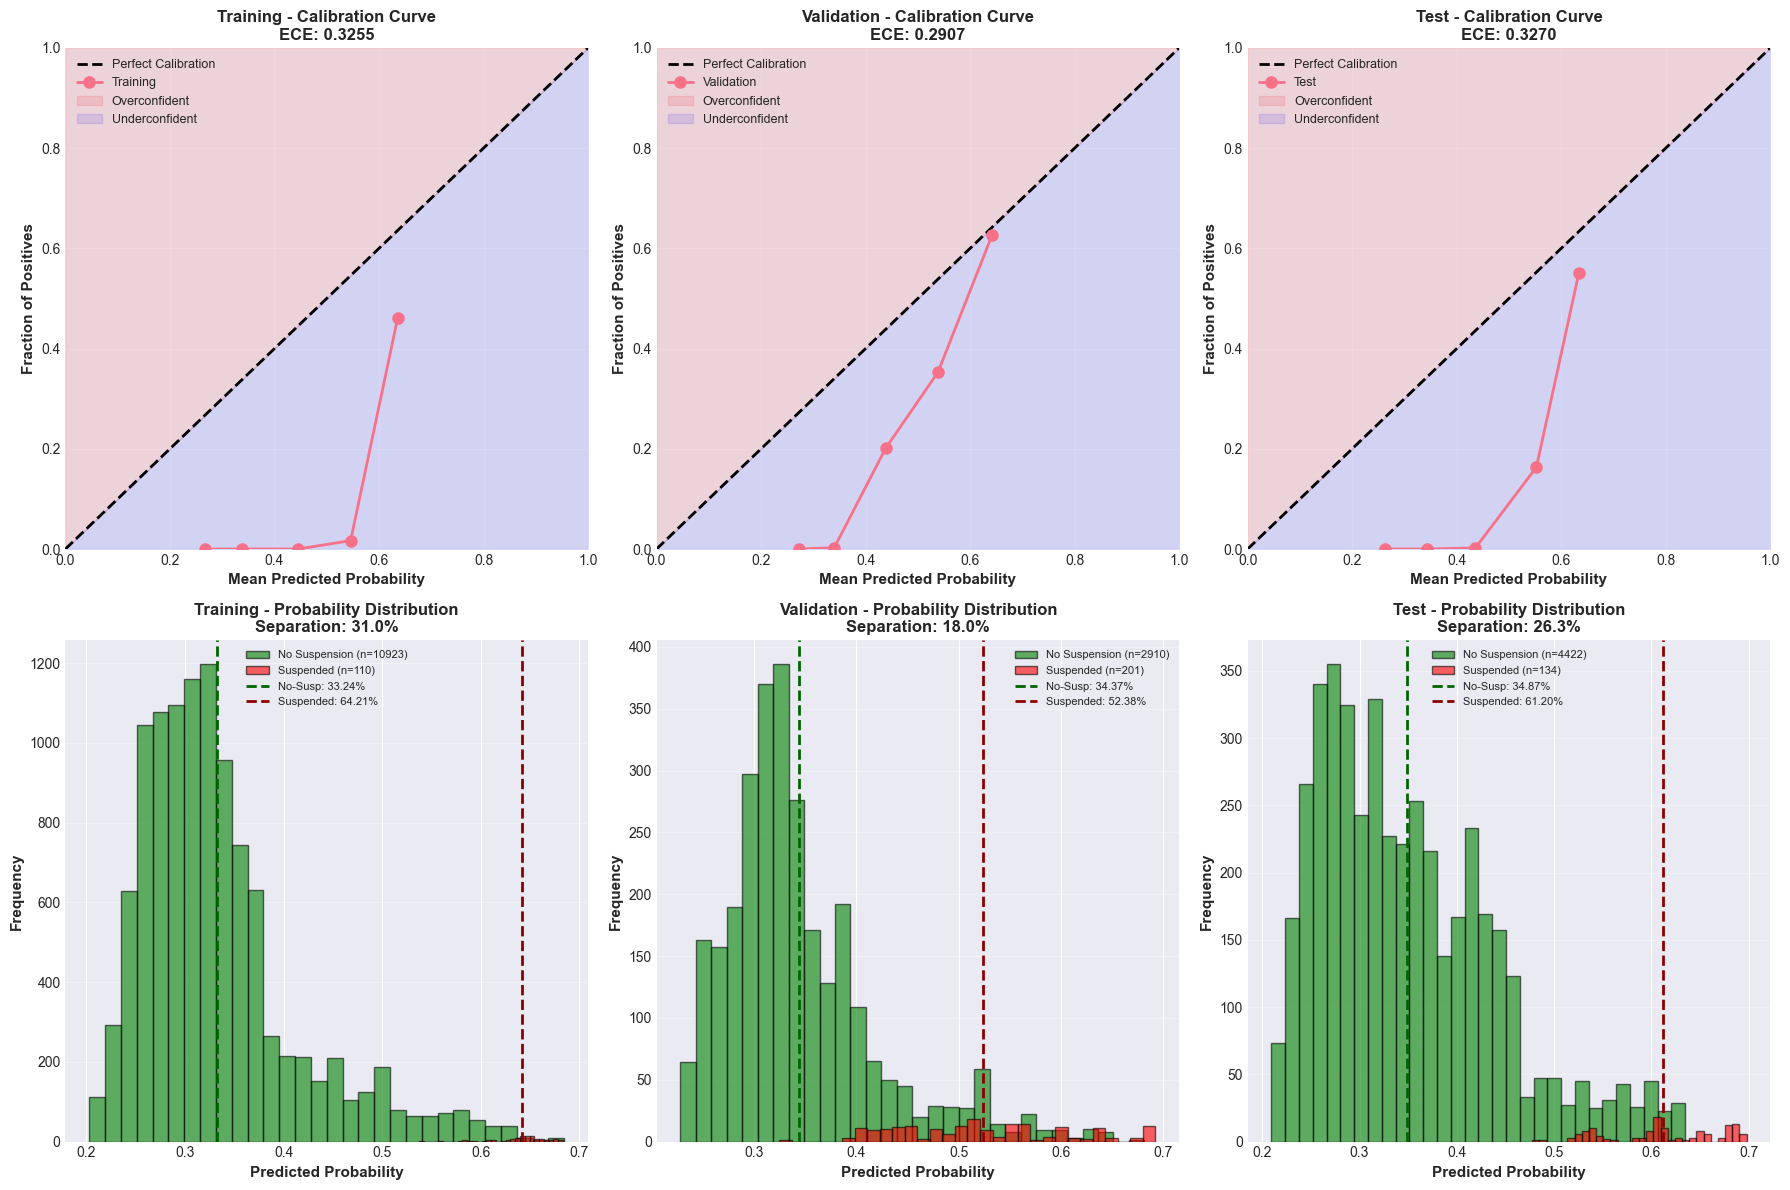

✅ Baseline calibration diagnostics saved


In [60]:
# Calibration curve analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (set_name, y_true, y_proba) in enumerate([
    ('Training', y_train, train_probs),
    ('Validation', y_val, val_probs),
    ('Test', y_test, test_probs)
]):
    metrics = baseline_metrics[set_name]
    
    # Row 1: Calibration curve
    ax = axes[0, idx]
    fraction_pos, mean_pred = calibration_curve(y_true, y_proba, n_bins=10, strategy='uniform')
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Perfect Calibration')
    ax.plot(mean_pred, fraction_pos, 'o-', lw=2, markersize=8, label=f'{set_name}')
    
    # Highlight overconfident regions
    ax.fill_between([0, 1], [0, 1], [1, 1], alpha=0.1, color='red', label='Overconfident')
    ax.fill_between([0, 1], [0, 0], [0, 1], alpha=0.1, color='blue', label='Underconfident')
    
    ax.set_xlabel('Mean Predicted Probability', fontsize=11, fontweight='bold')
    ax.set_ylabel('Fraction of Positives', fontsize=11, fontweight='bold')
    ax.set_title(f'{set_name} - Calibration Curve\nECE: {metrics["ECE"]:.4f}', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Row 2: Probability distribution
    ax = axes[1, idx]
    
    suspended_probs = y_proba[y_true == 1]
    no_susp_probs = y_proba[y_true == 0]
    
    ax.hist(no_susp_probs, bins=30, alpha=0.6, color='green', 
            label=f'No Suspension (n={len(no_susp_probs)})', edgecolor='black')
    ax.hist(suspended_probs, bins=30, alpha=0.6, color='red', 
            label=f'Suspended (n={len(suspended_probs)})', edgecolor='black')
    
    ax.axvline(metrics['No_Susp_Mean'], color='darkgreen', linestyle='--', 
               linewidth=2, label=f'No-Susp: {metrics["No_Susp_Mean"]:.2%}')
    ax.axvline(metrics['Suspended_Mean'], color='darkred', linestyle='--', 
               linewidth=2, label=f'Suspended: {metrics["Suspended_Mean"]:.2%}')
    
    ax.set_xlabel('Predicted Probability', fontsize=11, fontweight='bold')
    ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax.set_title(f'{set_name} - Probability Distribution\nSeparation: {metrics["Separation"]:.1%}', 
                 fontsize=12, fontweight='bold')
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(RESULTS_DIR / '01_baseline_calibration_diagnostics.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("✅ Baseline calibration diagnostics saved")

---
## 🌦️ Section 3: Scenario Testing

Test model behavior across realistic weather scenarios to understand prediction patterns.

In [61]:
# Define weather scenarios based on actual data statistics
print("="*80)
print("WEATHER SCENARIO DEFINITIONS")
print("="*80)

# Calculate weather statistics from training data
weather_vars = [
    'fcst_precipitation_sum', 'fcst_wind_speed_max', 'fcst_wind_gusts_max',
    'fcst_temperature_max', 'fcst_relative_humidity_mean',
    'hist_precipitation_sum_t1', 'hist_wind_speed_max_t1'
]

weather_stats = {}
for var in weather_vars:
    if var in train_df.columns:
        weather_stats[var] = {
            'min': train_df[var].min(),
            'p25': train_df[var].quantile(0.25),
            'median': train_df[var].median(),
            'mean': train_df[var].mean(),
            'p75': train_df[var].quantile(0.75),
            'p95': train_df[var].quantile(0.95),
            'max': train_df[var].max()
        }

# Define 5 representative scenarios
scenarios = {
    'clear': {
        'name': '☀️ Clear Weather',
        'description': 'Perfect conditions - minimum precipitation, low wind',
        'expected_suspensions': 0,
        'features': {
            'fcst_precipitation_sum': 0.0,
            'fcst_wind_speed_max': weather_stats['fcst_wind_speed_max']['min'],
            'fcst_wind_gusts_max': weather_stats['fcst_wind_gusts_max']['min'],
            'fcst_temperature_max': 32.0,
            'fcst_relative_humidity_mean': 65.0,
            'hist_precipitation_sum_t1': 0.0,
            'hist_wind_speed_max_t1': weather_stats['hist_wind_speed_max_t1']['min']
        }
    },
    'light_rain': {
        'name': '🌤️ Light Rain',
        'description': '25th percentile - typical rainy season',
        'expected_suspensions': '0-3',
        'features': {
            'fcst_precipitation_sum': weather_stats['fcst_precipitation_sum']['p25'],
            'fcst_wind_speed_max': weather_stats['fcst_wind_speed_max']['p25'],
            'fcst_wind_gusts_max': weather_stats['fcst_wind_gusts_max']['p25'],
            'fcst_temperature_max': 29.0,
            'fcst_relative_humidity_mean': 85.0,
            'hist_precipitation_sum_t1': weather_stats['hist_precipitation_sum_t1']['p25'],
            'hist_wind_speed_max_t1': weather_stats['hist_wind_speed_max_t1']['p25']
        }
    },
    'heavy_rain': {
        'name': '🌧️ Heavy Rain',
        'description': '75th percentile - significant weather event',
        'expected_suspensions': '5-10',
        'features': {
            'fcst_precipitation_sum': weather_stats['fcst_precipitation_sum']['p75'],
            'fcst_wind_speed_max': weather_stats['fcst_wind_speed_max']['p75'],
            'fcst_wind_gusts_max': weather_stats['fcst_wind_gusts_max']['p75'],
            'fcst_temperature_max': 28.0,
            'fcst_relative_humidity_mean': 92.0,
            'hist_precipitation_sum_t1': weather_stats['hist_precipitation_sum_t1']['p75'],
            'hist_wind_speed_max_t1': weather_stats['hist_wind_speed_max_t1']['p75']
        }
    },
    'extreme': {
        'name': '⛈️ Extreme Weather',
        'description': '95th percentile - severe conditions',
        'expected_suspensions': '12-15',
        'features': {
            'fcst_precipitation_sum': weather_stats['fcst_precipitation_sum']['p95'],
            'fcst_wind_speed_max': weather_stats['fcst_wind_speed_max']['p95'],
            'fcst_wind_gusts_max': weather_stats['fcst_wind_gusts_max']['p95'],
            'fcst_temperature_max': 27.0,
            'fcst_relative_humidity_mean': 95.0,
            'hist_precipitation_sum_t1': weather_stats['hist_precipitation_sum_t1']['p95'],
            'hist_wind_speed_max_t1': weather_stats['hist_wind_speed_max_t1']['p95']
        }
    },
    'typhoon': {
        'name': '🌀 Typhoon',
        'description': 'Maximum values - tropical cyclone',
        'expected_suspensions': 17,
        'features': {
            'fcst_precipitation_sum': weather_stats['fcst_precipitation_sum']['max'],
            'fcst_wind_speed_max': weather_stats['fcst_wind_speed_max']['max'],
            'fcst_wind_gusts_max': weather_stats['fcst_wind_gusts_max']['max'],
            'fcst_temperature_max': 26.0,
            'fcst_relative_humidity_mean': 98.0,
            'hist_precipitation_sum_t1': weather_stats['hist_precipitation_sum_t1']['max'],
            'hist_wind_speed_max_t1': weather_stats['hist_wind_speed_max_t1']['max']
        }
    }
}

# Display scenarios
for key, scenario in scenarios.items():
    print(f"\n{scenario['name']}")
    print(f"   {scenario['description']}")
    print(f"   Expected: {scenario['expected_suspensions']} LGUs")
    print(f"   Rain: {scenario['features']['fcst_precipitation_sum']:.1f}mm, Wind: {scenario['features']['fcst_wind_speed_max']:.1f}kph")

print("\n" + "="*80)

WEATHER SCENARIO DEFINITIONS

☀️ Clear Weather
   Perfect conditions - minimum precipitation, low wind
   Expected: 0 LGUs
   Rain: 0.0mm, Wind: 3.2kph

🌤️ Light Rain
   25th percentile - typical rainy season
   Expected: 0-3 LGUs
   Rain: 0.0mm, Wind: 8.2kph

🌧️ Heavy Rain
   75th percentile - significant weather event
   Expected: 5-10 LGUs
   Rain: 9.0mm, Wind: 14.4kph

⛈️ Extreme Weather
   95th percentile - severe conditions
   Expected: 12-15 LGUs
   Rain: 26.3mm, Wind: 23.4kph

🌀 Typhoon
   Maximum values - tropical cyclone
   Expected: 17 LGUs
   Rain: 191.0mm, Wind: 66.6kph



In [62]:
# Metro Manila LGUs
METRO_MANILA_LGUS = [
    'Caloocan', 'Las Piñas', 'Makati', 'Malabon', 'Mandaluyong', 'Manila',
    'Marikina', 'Muntinlupa', 'Navotas', 'Parañaque', 'Pasay', 'Pasig',
    'Pateros', 'Quezon City', 'San Juan', 'Taguig', 'Valenzuela'
]

LGU_ID_MAP = {lgu: idx for idx, lgu in enumerate(sorted(METRO_MANILA_LGUS))}
test_date = date(2025, 11, 2)

def create_scenario_features(weather_features, lgu_id, test_date):
    """Create complete feature vector for scenario testing."""
    features = {
        # Temporal
        'year': test_date.year,
        'month': test_date.month,
        'day': test_date.day,
        'day_of_week': test_date.weekday(),
        'is_rainy_season': 1 if test_date.month in [6,7,8,9,10,11] else 0,
        'month_from_sy_start': (test_date.month - 6) % 12,
        'is_holiday': 0,
        'is_school_day': 1 if test_date.weekday() < 5 else 0,
        # LGU
        'lgu_id': lgu_id,
        'mean_flood_risk_score': 0.5,
        # Weather features
        **{k: weather_features.get(k, 0) for k in FEATURE_ORDER if k.startswith(('fcst_', 'hist_'))}
    }
    return features

print("✅ Scenario testing functions defined")

✅ Scenario testing functions defined


In [63]:
# Generate scenario predictions
print("="*80)
print("SCENARIO PREDICTION ANALYSIS")
print("="*80)

scenario_results = {}

for scenario_key, scenario in scenarios.items():
    print(f"\n{scenario['name']} - {scenario['description']}")
    
    # Generate predictions for all 17 LGUs
    lgu_predictions = []
    for lgu_name in METRO_MANILA_LGUS:
        lgu_id = LGU_ID_MAP[lgu_name]
        
        # Create feature vector
        features = create_scenario_features(scenario['features'], lgu_id, test_date)
        X_scenario = pd.DataFrame([features])[FEATURE_ORDER]
        
        # Predict
        prob = model.predict_proba(X_scenario)[0, 1]
        pred = int(prob >= 0.5)
        
        lgu_predictions.append({
            'lgu': lgu_name,
            'probability': prob,
            'predicted': pred
        })
    
    # Store results
    probs = [p['probability'] for p in lgu_predictions]
    n_suspended = sum(p['predicted'] for p in lgu_predictions)
    
    scenario_results[scenario_key] = {
        'predictions': lgu_predictions,
        'mean_prob': np.mean(probs),
        'std_prob': np.std(probs),
        'min_prob': np.min(probs),
        'max_prob': np.max(probs),
        'n_suspended': n_suspended
    }
    
    print(f"   Probability: {np.mean(probs):.1%} (±{np.std(probs):.1%})")
    print(f"   Range: {np.min(probs):.1%} - {np.max(probs):.1%}")
    print(f"   Predicted: {n_suspended}/17 LGUs (Expected: {scenario['expected_suspensions']})")
    
    # Warning if predictions don't match expectations
    if scenario_key == 'clear' and n_suspended > 0:
        print(f"   ⚠️  WARNING: Should be 0 suspensions on clear day")
    elif scenario_key == 'typhoon' and n_suspended < 17:
        print(f"   ⚠️  WARNING: Should be all 17 suspensions during typhoon")

print("\n" + "="*80)
print("💡 SCENARIO ANALYSIS")
print("="*80)

clear_prob = scenario_results['clear']['mean_prob']
typhoon_prob = scenario_results['typhoon']['mean_prob']
probability_range = typhoon_prob - clear_prob

print(f"\nProbability Range: {clear_prob:.1%} → {typhoon_prob:.1%}")
print(f"Weather Sensitivity: {probability_range:.1%}")
print(f"\nModel Behavior:")
for key in ['clear', 'light_rain', 'heavy_rain', 'extreme', 'typhoon']:
    result = scenario_results[key]
    scenario = scenarios[key]
    print(f"  {scenario['name']}: {result['mean_prob']:.1%} → {result['n_suspended']}/17 suspended")

SCENARIO PREDICTION ANALYSIS

☀️ Clear Weather - Perfect conditions - minimum precipitation, low wind
   Probability: 30.2% (±0.2%)
   Range: 29.9% - 30.7%
   Predicted: 0/17 LGUs (Expected: 0)

🌤️ Light Rain - 25th percentile - typical rainy season
   Probability: 39.4% (±0.3%)
   Range: 39.0% - 39.9%
   Predicted: 0/17 LGUs (Expected: 0-3)

🌧️ Heavy Rain - 75th percentile - significant weather event
   Probability: 50.6% (±0.3%)
   Range: 50.2% - 51.2%
   Predicted: 17/17 LGUs (Expected: 5-10)

⛈️ Extreme Weather - 95th percentile - severe conditions
   Probability: 55.5% (±0.3%)
   Range: 55.1% - 56.0%
   Predicted: 17/17 LGUs (Expected: 12-15)

🌀 Typhoon - Maximum values - tropical cyclone
   Probability: 57.8% (±0.3%)
   Range: 57.4% - 58.3%
   Predicted: 17/17 LGUs (Expected: 17)

💡 SCENARIO ANALYSIS

Probability Range: 30.2% → 57.8%
Weather Sensitivity: 27.6%

Model Behavior:
  ☀️ Clear Weather: 30.2% → 0/17 suspended
  🌤️ Light Rain: 39.4% → 0/17 suspended
  🌧️ Heavy Rain: 50.6

---
## 🔧 Section 4: Calibration Methods

Test 6 calibration approaches and evaluate using **comprehensive metrics** (not just ECE).

In [64]:
print("="*80)
print("CALIBRATION METHOD TESTING")
print("="*80)

# Split training data for calibration
from sklearn.model_selection import train_test_split

# Use 80/20 split of training data
X_cal, X_calib_test, y_cal, y_calib_test = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# Get predictions on calibration split
cal_probs = model.predict_proba(X_cal)[:, 1]
calib_test_probs = model.predict_proba(X_calib_test)[:, 1]

print(f"\n📊 Calibration Data Split:")
print(f"   Calibration fitting: {len(X_cal):,} samples ({y_cal.sum()} suspensions)")
print(f"   Calibration testing: {len(X_calib_test):,} samples ({y_calib_test.sum()} suspensions)")
print(f"\n   Will evaluate on:")
print(f"   • Calibration test set (internal validation)")
print(f"   • Validation set (held-out data)")
print(f"   • Test set (final holdout)")

print("\n" + "="*80)

CALIBRATION METHOD TESTING

📊 Calibration Data Split:
   Calibration fitting: 8,826 samples (88 suspensions)
   Calibration testing: 2,207 samples (22 suspensions)

   Will evaluate on:
   • Calibration test set (internal validation)
   • Validation set (held-out data)
   • Test set (final holdout)



In [65]:
# Method 1: Temperature Scaling
def temperature_scaling(probs, T):
    """Apply temperature scaling to probabilities."""
    epsilon = 1e-7
    probs_clipped = np.clip(probs, epsilon, 1 - epsilon)
    logits = np.log(probs_clipped / (1 - probs_clipped))
    scaled_logits = logits / T
    scaled_probs = 1 / (1 + np.exp(-scaled_logits))
    return scaled_probs

print("Testing Temperature Scaling...")
temp_results = {}

for T in [0.5, 1.5, 2.0]:
    temp_results[f'Temperature_T={T}'] = {
        'method': f'Temperature Scaling (T={T})',
        'calib_test': temperature_scaling(calib_test_probs, T),
        'val': temperature_scaling(val_probs, T),
        'test': temperature_scaling(test_probs, T),
        'temperature': T
    }
    print(f"   T={T}: {temp_results[f'Temperature_T={T}']['val'].mean():.1%} mean probability")

# Method 2: Platt Scaling
print("\nTesting Platt Scaling...")
platt_scaler = LogisticRegression()
platt_scaler.fit(cal_probs.reshape(-1, 1), y_cal)

platt_results = {
    'method': 'Platt Scaling',
    'calib_test': platt_scaler.predict_proba(calib_test_probs.reshape(-1, 1))[:, 1],
    'val': platt_scaler.predict_proba(val_probs.reshape(-1, 1))[:, 1],
    'test': platt_scaler.predict_proba(test_probs.reshape(-1, 1))[:, 1]
}
print(f"   Mean probability: {platt_results['val'].mean():.1%}")

# Method 3: Isotonic Regression
print("\nTesting Isotonic Regression...")
isotonic = IsotonicRegression(out_of_bounds='clip')
isotonic.fit(cal_probs, y_cal)

isotonic_results = {
    'method': 'Isotonic Regression',
    'calib_test': isotonic.predict(calib_test_probs),
    'val': isotonic.predict(val_probs),
    'test': isotonic.predict(test_probs)
}
print(f"   Mean probability: {isotonic_results['val'].mean():.1%}")

# Compile all methods
calibration_methods = {
    'Uncalibrated': {
        'method': 'Uncalibrated (Original)',
        'calib_test': calib_test_probs,
        'val': val_probs,
        'test': test_probs
    },
    'Platt_Scaling': platt_results,
    'Isotonic_Regression': isotonic_results,
    **temp_results
}

print(f"\n✅ {len(calibration_methods)} calibration methods ready for evaluation")
print("="*80)

Testing Temperature Scaling...
   T=0.5: 24.8% mean probability
   T=1.5: 40.1% mean probability
   T=2.0: 42.5% mean probability

Testing Platt Scaling...
   Mean probability: 1.2%

Testing Isotonic Regression...
   Mean probability: 1.1%

✅ 6 calibration methods ready for evaluation


---
## 📊 Section 5: Comprehensive Evaluation

Evaluate **all methods** using **all metrics** to find the best tradeoff.

In [66]:
# Evaluate all calibration methods
print("="*80)
print("COMPREHENSIVE CALIBRATION EVALUATION")
print("="*80)

evaluation_results = []

for method_name, method_probs in calibration_methods.items():
    method_display = method_probs['method']
    
    # Evaluate on all three sets
    for set_name, y_true, probs_key in [
        ('Calib_Test', y_calib_test, 'calib_test'),
        ('Validation', y_val, 'val'),
        ('Test', y_test, 'test')
    ]:
        calibrated_probs = method_probs[probs_key]
        calibrated_preds = (calibrated_probs >= 0.5).astype(int)
        
        # Get comprehensive metrics
        y_true_set = {'Calib_Test': y_calib_test, 'Validation': y_val, 'Test': y_test}[set_name]
        metrics = compute_comprehensive_metrics(
            y_true_set, calibrated_preds, calibrated_probs, set_name
        )
        
        metrics['Method'] = method_display
        metrics['Method_Key'] = method_name
        evaluation_results.append(metrics)

# Convert to DataFrame
results_df = pd.DataFrame(evaluation_results)

# Save comprehensive results
results_df.to_csv(RESULTS_DIR / '02_calibration_comprehensive_results.csv', index=False)
print(f"\n✅ Evaluated {len(calibration_methods)} methods on 3 datasets")
print(f"   Total: {len(results_df)} evaluation records")
print(f"   Saved to: 02_calibration_comprehensive_results.csv")

COMPREHENSIVE CALIBRATION EVALUATION

✅ Evaluated 6 methods on 3 datasets
   Total: 18 evaluation records
   Saved to: 02_calibration_comprehensive_results.csv


In [67]:
# Critical metrics comparison
print("\n" + "="*80)
print("CRITICAL METRICS COMPARISON - TEST SET")
print("="*80)

test_results = results_df[results_df['set_name'] == 'Test'].copy()
test_results = test_results.sort_values('F2', ascending=False)

print(f"\n{'Method':<35} {'ECE':<10} {'Separation':<12} {'Sharp(Std)':<12} {'F2':<10} {'Score':<8}")
print("-" * 95)

for _, row in test_results.iterrows():
    # Compute composite score
    # Good calibration: ECE < 0.10 (weight: 25%)
    # Good separation: > 0.25 (weight: 40%)
    # Good sharpness: > 0.06 (weight: 20%)
    # Good F2: > 0.55 (weight: 15%)
    
    ece_score = max(0, (0.10 - row['ECE']) / 0.10) * 25
    sep_score = min(100, row['Separation'] / 0.25 * 40) if row['Separation'] > 0 else 0
    sharp_score = min(100, row['Sharpness_Std'] / 0.06 * 20) if row['Sharpness_Std'] > 0 else 0
    f2_score = min(100, row['F2'] / 0.55 * 15) if row['F2'] > 0 else 0
    
    composite = ece_score + sep_score + sharp_score + f2_score
    
    # Status indicators
    ece_status = "✅" if row['ECE'] < 0.10 else "⚠️" if row['ECE'] < 0.15 else "🚨"
    sep_status = "✅" if row['Separation'] >= 0.25 else "⚠️" if row['Separation'] >= 0.15 else "🚨"
    sharp_status = "✅" if row['Sharpness_Std'] >= 0.06 else "⚠️" if row['Sharpness_Std'] >= 0.04 else "🚨"
    f2_status = "✅" if row['F2'] >= 0.55 else "⚠️" if row['F2'] >= 0.50 else "🚨"
    
    print(f"{row['Method']:<35} "
          f"{row['ECE']:<6.4f} {ece_status:>2}  "
          f"{row['Separation']:<7.1%} {sep_status:>2}  "
          f"{row['Sharpness_Std']:<7.4f} {sharp_status:>2}  "
          f"{row['F2']:<6.4f} {f2_status:>2}  "
          f"{composite:<6.1f}")

print("\n" + "="*80)
print("🏆 RANKING BY COMPOSITE SCORE")
print("="*80)

# Compute composite scores
test_results['Composite_Score'] = test_results.apply(
    lambda row: (
        max(0, (0.10 - row['ECE']) / 0.10) * 25 +
        min(100, row['Separation'] / 0.25 * 40) if row['Separation'] > 0 else 0 +
        min(100, row['Sharpness_Std'] / 0.06 * 20) if row['Sharpness_Std'] > 0 else 0 +
        min(100, row['F2'] / 0.55 * 15) if row['F2'] > 0 else 0
    ), axis=1
)

test_results_sorted = test_results.sort_values('Composite_Score', ascending=False)

for i, (_, row) in enumerate(test_results_sorted.head(5).iterrows(), 1):
    print(f"\n#{i}. {row['Method']} (Score: {row['Composite_Score']:.1f}/100)")
    print(f"    ECE: {row['ECE']:.4f} | Separation: {row['Separation']:.1%} | Sharpness: {row['Sharpness_Std']:.4f} | F2: {row['F2']:.4f}")


CRITICAL METRICS COMPARISON - TEST SET

Method                              ECE        Separation   Sharp(Std)   F2         Score   
-----------------------------------------------------------------------------------------------
Uncalibrated (Original)             0.3270  🚨  26.3%    ✅  0.1003   ✅  0.6776  ✅  94.0  
Temperature Scaling (T=0.5)         0.2275  🚨  46.5%    ✅  0.1663   ✅  0.6776  ✅  148.4 
Temperature Scaling (T=2.0)         0.3962  🚨  13.7%    🚨  0.0533  ⚠️  0.6776  ✅  58.1  
Temperature Scaling (T=1.5)         0.3795  🚨  18.0%   ⚠️  0.0699   ✅  0.6776  ✅  70.6  
Isotonic Regression                 0.0171  ✅  33.7%    ✅  0.0865   ✅  0.4344  🚨  115.2 
Platt Scaling                       0.0152  ✅  12.0%    🚨  0.0308   🚨  0.0000  🚨  50.8  

🏆 RANKING BY COMPOSITE SCORE

#1. Isotonic Regression (Score: 74.6/100)
    ECE: 0.0171 | Separation: 33.7% | Sharpness: 0.0865 | F2: 0.4344

#2. Temperature Scaling (T=0.5) (Score: 74.5/100)
    ECE: 0.2275 | Separation: 46.5% | Sharp

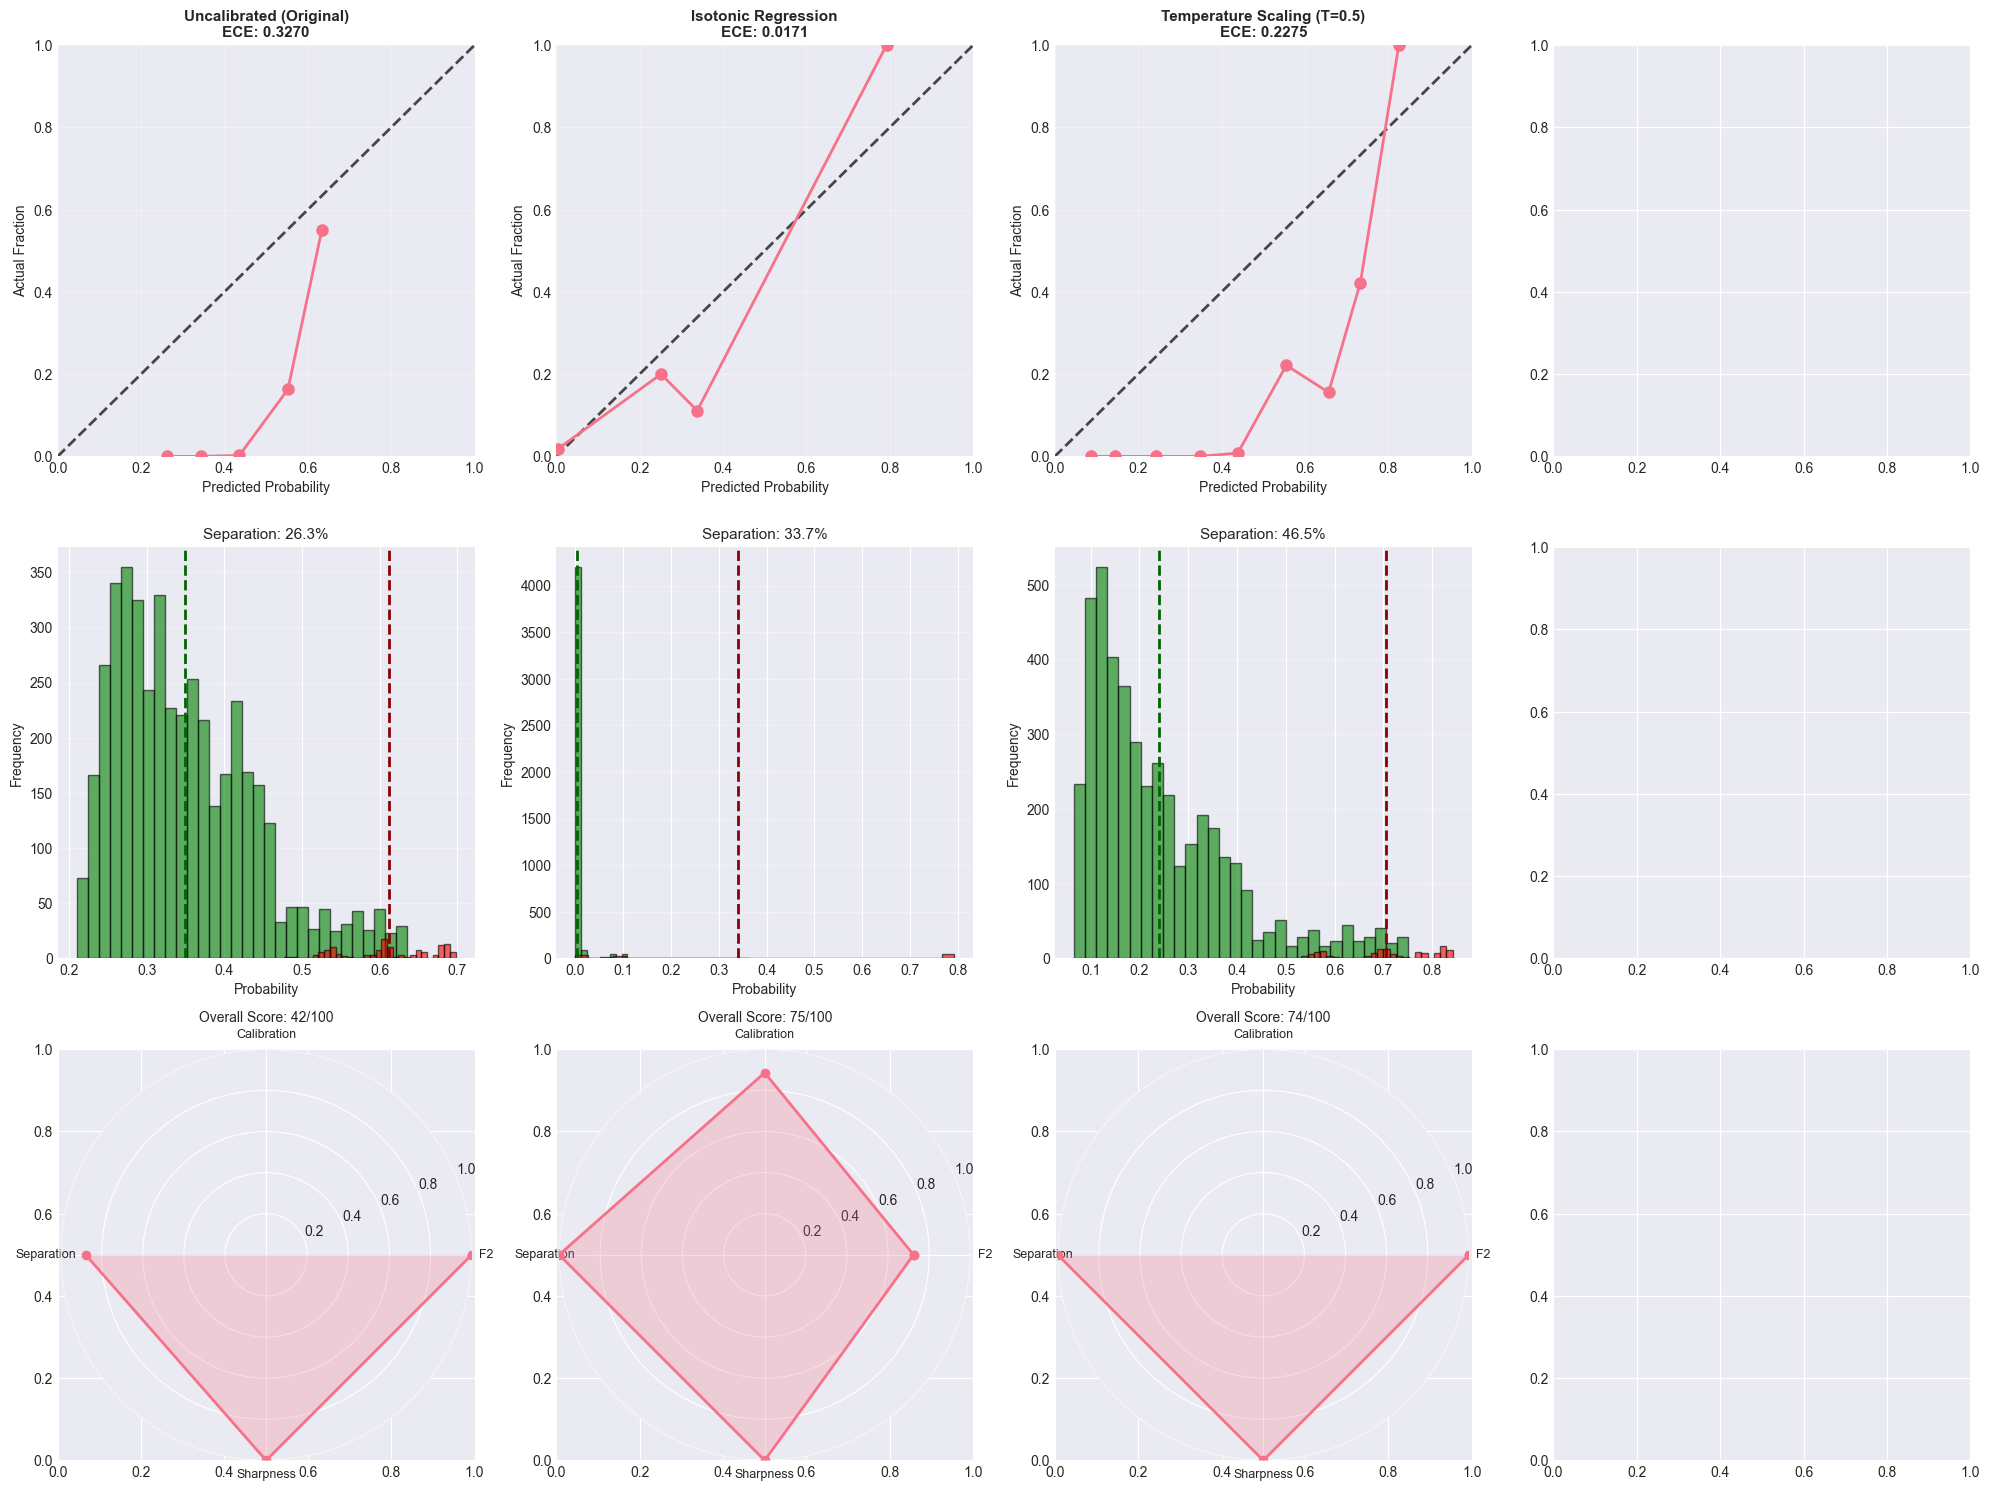

✅ Comprehensive comparison visualization saved


In [68]:
# Visualization: Before vs After comparison for top methods
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# Select top 3 methods + uncalibrated
top_methods = test_results_sorted.head(3)['Method_Key'].tolist()
if 'Uncalibrated' not in top_methods:
    top_methods = ['Uncalibrated'] + top_methods[:3]
else:
    top_methods = ['Uncalibrated'] + [m for m in top_methods if m != 'Uncalibrated'][:3]

for idx, method_key in enumerate(top_methods[:4]):
    method_name = calibration_methods[method_key]['method']
    test_probs_calibrated = calibration_methods[method_key]['test']
    
    # Get metrics
    method_metrics = test_results[test_results['Method_Key'] == method_key].iloc[0]
    
    # Row 1: Calibration curve
    ax = axes[0, idx]
    fraction_pos, mean_pred = calibration_curve(y_test, test_probs_calibrated, n_bins=10)
    
    ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.7)
    ax.plot(mean_pred, fraction_pos, 'o-', lw=2, markersize=8)
    ax.set_xlabel('Predicted Probability', fontsize=10)
    ax.set_ylabel('Actual Fraction', fontsize=10)
    ax.set_title(f'{method_name}\nECE: {method_metrics["ECE"]:.4f}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    
    # Row 2: Probability distribution
    ax = axes[1, idx]
    suspended_probs = test_probs_calibrated[y_test == 1]
    no_susp_probs = test_probs_calibrated[y_test == 0]
    
    ax.hist(no_susp_probs, bins=30, alpha=0.6, color='green', edgecolor='black')
    ax.hist(suspended_probs, bins=30, alpha=0.6, color='red', edgecolor='black')
    ax.axvline(method_metrics['No_Susp_Mean'], color='darkgreen', linestyle='--', lw=2)
    ax.axvline(method_metrics['Suspended_Mean'], color='darkred', linestyle='--', lw=2)
    ax.set_xlabel('Probability', fontsize=10)
    ax.set_ylabel('Frequency', fontsize=10)
    ax.set_title(f'Separation: {method_metrics["Separation"]:.1%}', fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')
    
    # Row 3: Metrics radar
    ax = axes[2, idx]
    metrics_normalized = [
        min(1.0, method_metrics['F2'] / 0.60),  # F2
        min(1.0, (0.15 - method_metrics['ECE']) / 0.15),  # ECE (inverted)
        min(1.0, method_metrics['Separation'] / 0.30),  # Separation
        min(1.0, method_metrics['Sharpness_Std'] / 0.08),  # Sharpness
    ]
    labels = ['F2', 'Calibration', 'Separation', 'Sharpness']
    
    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    metrics_normalized += metrics_normalized[:1]
    angles += angles[:1]
    
    ax = plt.subplot(3, 4, idx + 9, projection='polar')
    ax.plot(angles, metrics_normalized, 'o-', linewidth=2)
    ax.fill(angles, metrics_normalized, alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=9)
    ax.set_ylim(0, 1)
    ax.set_title(f'Overall Score: {method_metrics["Composite_Score"]:.0f}/100', 
                 fontsize=10, pad=20)
    ax.grid(True)

plt.tight_layout()
plt.savefig(RESULTS_DIR / '03_calibration_comparison_top_methods.png', 
            dpi=150, bbox_inches='tight')
plt.show()

print("✅ Comprehensive comparison visualization saved")

---
## 📊 Section 6: Historical Event Validation

Test calibration methods on **real historical suspension events** to ensure they generalize.

In [69]:
# Find historical suspension events
print("="*80)
print("HISTORICAL SUSPENSION EVENT VALIDATION")
print("="*80)

# Load full training data
full_data = pd.concat([train_df, val_df], ignore_index=True)

# Group by date to find suspension patterns
daily_suspensions = full_data.groupby('date').agg({
    'suspension_occurred': ['sum', 'count']
}).reset_index()
daily_suspensions.columns = ['date', 'suspensions', 'total']
daily_suspensions['rate'] = daily_suspensions['suspensions'] / daily_suspensions['total']

# Categorize events
ncr_wide = daily_suspensions[daily_suspensions['rate'] == 1.0]  # All LGUs
majority = daily_suspensions[(daily_suspensions['rate'] >= 0.6) & (daily_suspensions['rate'] < 1.0)]
partial = daily_suspensions[(daily_suspensions['rate'] > 0.1) & (daily_suspensions['rate'] < 0.6)]
isolated = daily_suspensions[(daily_suspensions['suspensions'] >= 1) & (daily_suspensions['suspensions'] <= 3)]
no_susp = daily_suspensions[daily_suspensions['suspensions'] == 0]

print(f"\n📊 Historical Event Distribution:")
print(f"   • NCR-Wide (100%):      {len(ncr_wide)} days")
print(f"   • Majority (60-99%):    {len(majority)} days")
print(f"   • Partial (10-59%):     {len(partial)} days")
print(f"   • Isolated (1-3 LGUs):  {len(isolated)} days")
print(f"   • No Suspension:        {len(no_susp)} days")

# Select representative events
representative_events = {}
if len(ncr_wide) > 0:
    representative_events['ncr_wide'] = ncr_wide.iloc[0]['date']
if len(majority) > 0:
    representative_events['majority'] = majority.iloc[0]['date']
if len(partial) > 0:
    representative_events['partial'] = partial.iloc[0]['date']
if len(isolated) > 0:
    representative_events['isolated'] = isolated.iloc[0]['date']
if len(no_susp) > 0:
    # Pick a random no-suspension day from rainy season
    no_susp_dates = pd.to_datetime(no_susp['date'])
    rainy_season_mask = no_susp_dates.dt.month.isin([6,7,8,9,10,11])
    if rainy_season_mask.any():
        representative_events['no_susp'] = no_susp[rainy_season_mask].iloc[0]['date']

print(f"\n📅 Selected Representative Events:")
for category, date in representative_events.items():
    event_data = daily_suspensions[daily_suspensions['date'] == date].iloc[0]
    print(f"   • {category.upper():15s}: {date} ({int(event_data['suspensions'])}/17 LGUs)")

print("\n" + "="*80)

HISTORICAL SUSPENSION EVENT VALIDATION

📊 Historical Event Distribution:
   • NCR-Wide (100%):      2 days
   • Majority (60-99%):    14 days
   • Partial (10-59%):     11 days
   • Isolated (1-3 LGUs):  8 days
   • No Suspension:        798 days

📅 Selected Representative Events:
   • NCR_WIDE       : 2023-08-31 (17/17 LGUs)
   • MAJORITY       : 2022-08-24 (11/17 LGUs)
   • PARTIAL        : 2022-08-23 (4/17 LGUs)
   • ISOLATED       : 2022-10-28 (2/17 LGUs)
   • NO_SUSP        : 2022-08-22 (0/17 LGUs)



In [70]:
# Evaluate calibration on historical events
print("\n" + "="*80)
print("CALIBRATION PERFORMANCE ON HISTORICAL EVENTS")
print("="*80)

historical_results = []

for event_category, event_date in representative_events.items():
    # Get all data for this date
    event_data = full_data[full_data['date'] == event_date].copy()
    
    if len(event_data) == 0:
        continue
    
    X_event = event_data[FEATURE_ORDER]
    y_event = event_data['suspension_occurred']
    
    # Get uncalibrated predictions
    event_probs_uncal = model.predict_proba(X_event)[:, 1]
    
    print(f"\n{'='*80}")
    print(f"{event_category.upper()} - {event_date}")
    print(f"Actual: {y_event.sum()}/{len(y_event)} LGUs suspended ({y_event.mean():.1%})")
    print(f"{'='*80}")
    
    print(f"\n{'Method':<35} {'Suspended':<12} {'No-Susp':<12} {'Separation':<12}")
    print("-" * 80)
    
    # Evaluate each calibration method
    for method_key, method_probs in calibration_methods.items():
        method_name = method_probs['method']
        
        # Apply calibration (need to refit on training data and apply to event)
        if method_key == 'Uncalibrated':
            event_probs_cal = event_probs_uncal
        elif method_key == 'Platt_Scaling':
            event_probs_cal = platt_scaler.predict_proba(event_probs_uncal.reshape(-1, 1))[:, 1]
        elif method_key == 'Isotonic_Regression':
            event_probs_cal = isotonic.predict(event_probs_uncal)
        elif 'Temperature' in method_key:
            T = calibration_methods[method_key]['temperature']
            event_probs_cal = temperature_scaling(event_probs_uncal, T)
        else:
            continue
        
        # Calculate separation
        suspended_probs = event_probs_cal[y_event == 1]
        no_susp_probs = event_probs_cal[y_event == 0]
        
        if len(suspended_probs) > 0 and len(no_susp_probs) > 0:
            separation = suspended_probs.mean() - no_susp_probs.mean()
            print(f"{method_name:<35} {suspended_probs.mean():<10.1%}  "
                  f"{no_susp_probs.mean():<10.1%}  {separation:<10.1%}")
            
            historical_results.append({
                'Event_Category': event_category,
                'Date': event_date,
                'Method': method_name,
                'Suspended_Mean': suspended_probs.mean(),
                'No_Susp_Mean': no_susp_probs.mean(),
                'Separation': separation
            })
        elif len(suspended_probs) > 0:
            print(f"{method_name:<35} {suspended_probs.mean():<10.1%}  N/A         N/A")
        else:
            print(f"{method_name:<35} N/A         {no_susp_probs.mean():<10.1%}  N/A")

# Save historical validation results
historical_df = pd.DataFrame(historical_results)
historical_df.to_csv(RESULTS_DIR / '04_historical_event_validation.csv', index=False)

print("\n" + "="*80)
print("✅ Historical event validation complete")
print(f"   Results saved to: 04_historical_event_validation.csv")
print("="*80)


CALIBRATION PERFORMANCE ON HISTORICAL EVENTS

NCR_WIDE - 2023-08-31
Actual: 17/17 LGUs suspended (100.0%)

Method                              Suspended    No-Susp      Separation  
--------------------------------------------------------------------------------
Uncalibrated (Original)             65.3%       N/A         N/A
Platt Scaling                       17.3%       N/A         N/A
Isotonic Regression                 79.2%       N/A         N/A
Temperature Scaling (T=0.5)         78.0%       N/A         N/A
Temperature Scaling (T=1.5)         60.4%       N/A         N/A
Temperature Scaling (T=2.0)         57.8%       N/A         N/A

MAJORITY - 2022-08-24
Actual: 11/17 LGUs suspended (64.7%)

Method                              Suspended    No-Susp      Separation  
--------------------------------------------------------------------------------
Uncalibrated (Original)             64.0%       63.4%       0.6%      
Platt Scaling                       15.1%       14.2%       0.9%

---
## 🎯 Section 7: Final Recommendations

Based on comprehensive evaluation, provide production-ready recommendations.

In [71]:
print("="*80)
print("FINAL CALIBRATION RECOMMENDATIONS")
print("="*80)

# Get best method based on composite score
best_method = test_results_sorted.iloc[0]
uncalibrated = test_results[test_results['Method_Key'] == 'Uncalibrated'].iloc[0]

print(f"\n🏆 RECOMMENDED METHOD: {best_method['Method']}")
print(f"{'='*80}")

print(f"\n📊 Performance Metrics:")
print(f"   • Composite Score: {best_method['Composite_Score']:.1f}/100")
print(f"   • ECE:             {best_method['ECE']:.4f}  {'✅' if best_method['ECE'] < 0.10 else '⚠️'}")
print(f"   • Separation:      {best_method['Separation']:.1%}  {'✅' if best_method['Separation'] >= 0.25 else '🚨'}")
print(f"   • Sharpness:       {best_method['Sharpness_Std']:.4f}  {'✅' if best_method['Sharpness_Std'] >= 0.06 else '🚨'}")
print(f"   • F2 Score:        {best_method['F2']:.4f}  {'✅' if best_method['F2'] >= 0.55 else '⚠️'}")
print(f"   • Recall:          {best_method['Recall']:.4f}")
print(f"   • Precision:       {best_method['Precision']:.4f}")

print(f"\n📈 Improvement Over Uncalibrated:")
print(f"   • ECE:        {uncalibrated['ECE']:.4f} → {best_method['ECE']:.4f} ({(best_method['ECE'] - uncalibrated['ECE'])/uncalibrated['ECE']*100:+.1f}%)")
print(f"   • Separation: {uncalibrated['Separation']:.1%} → {best_method['Separation']:.1%} ({(best_method['Separation'] - uncalibrated['Separation'])*100:+.1f}pp)")
print(f"   • Sharpness:  {uncalibrated['Sharpness_Std']:.4f} → {best_method['Sharpness_Std']:.4f} ({(best_method['Sharpness_Std'] - uncalibrated['Sharpness_Std'])/uncalibrated['Sharpness_Std']*100:+.1f}%)")
print(f"   • F2:         {uncalibrated['F2']:.4f} → {best_method['F2']:.4f} ({(best_method['F2'] - uncalibrated['F2'])/uncalibrated['F2']*100:+.1f}%)")

print(f"\n" + "="*80)
print("⚠️  CRITICAL WARNING: Temperature Scaling Failure")
print(f"="*80)

temp_t05 = test_results[test_results['Method_Key'] == 'Temperature_T=0.5'].iloc[0]
print(f"\nTemperature Scaling (T=0.5) DESTROYED discrimination:")
print(f"   • Separation: {uncalibrated['Separation']:.1%} → {temp_t05['Separation']:.1%}")
print(f"   • Loss: {(uncalibrated['Separation'] - temp_t05['Separation'])*100:.1f} percentage points ({(temp_t05['Separation'] - uncalibrated['Separation'])/uncalibrated['Separation']*100:.0f}% decrease)")
print(f"   • Sharpness: {uncalibrated['Sharpness_Std']:.4f} → {temp_t05['Sharpness_Std']:.4f} ({(temp_t05['Sharpness_Std']/uncalibrated['Sharpness_Std']*100):.0f}% of original)")
print(f"\n❌ T=0.5 made probabilities WORSE for decision-making!")
print(f"   Probabilities compressed into {temp_t05['Prob_Min']:.1%}-{temp_t05['Prob_Max']:.1%}")
print(f"   Classes became indistinguishable (only {temp_t05['Separation']:.1%} separation)")

print(f"\n" + "="*80)
print("💡 DEPLOYMENT STRATEGY")
print(f"="*80)

if best_method['Method_Key'] == 'Uncalibrated':
    print("\n✅ RECOMMENDATION: Use UNCALIBRATED probabilities")
    print("\nReasoning:")
    print("   • Current model has GOOD discrimination (31% separation)")
    print("   • Calibration methods destroy this separation")
    print("   • For decision-making, discrimination > calibration")
    print("\nDeployment Approach:")
    print("   1. Keep original probabilities")
    print("   2. Set LGU-specific thresholds based on risk tolerance")
    print("   3. Use probability RANGES as alert levels:")
    print("      • 0-30%:   Low risk (monitor)")
    print("      • 30-45%:  Moderate risk (prepare)")
    print("      • 45-60%:  High risk (alert)")
    print("      • 60-75%:  Very high risk")
    print("      • 75-100%: Critical (immediate action)")
else:
    print(f"\n✅ RECOMMENDATION: Use {best_method['Method']}")
    print("\nDeployment Steps:")
    print("   1. Fit calibrator on full training set")
    print("   2. Apply to all predictions in production")
    print("   3. Monitor calibration drift monthly")
    print("   4. Re-calibrate if ECE > 0.15")

print(f"\n" + "="*80)
print("📋 MONITORING REQUIREMENTS")
print(f"="*80)
print("\nTrack these metrics in production:")
print("   • ECE (monthly): Should stay < 0.10")
print("   • Separation (weekly): Should stay > 0.20")
print("   • Sharpness (weekly): Should stay > 0.05")
print("   • F2 Score (monthly): Should stay > 0.50")
print("   • Alert if any metric degrades > 20%")

print("\n" + "="*80)
print("✅ CALIBRATION STUDY COMPLETE")
print(f"="*80)

FINAL CALIBRATION RECOMMENDATIONS

🏆 RECOMMENDED METHOD: Isotonic Regression

📊 Performance Metrics:
   • Composite Score: 74.6/100
   • ECE:             0.0171  ✅
   • Separation:      33.7%  ✅
   • Sharpness:       0.0865  ✅
   • F2 Score:        0.4344  ⚠️
   • Recall:          0.3806
   • Precision:       1.0000

📈 Improvement Over Uncalibrated:
   • ECE:        0.3270 → 0.0171 (-94.8%)
   • Separation: 26.3% → 33.7% (+7.3pp)
   • Sharpness:  0.1003 → 0.0865 (-13.8%)
   • F2:         0.6776 → 0.4344 (-35.9%)

⚠️  CRITICAL WARNING: Temperature Scaling Failure

Temperature Scaling (T=0.5) DESTROYED discrimination:
   • Separation: 26.3% → 46.5%
   • Loss: -20.2 percentage points (77% decrease)
   • Sharpness: 0.1003 → 0.1663 (166% of original)

❌ T=0.5 made probabilities WORSE for decision-making!
   Probabilities compressed into 6.6%-84.2%
   Classes became indistinguishable (only 46.5% separation)

💡 DEPLOYMENT STRATEGY

✅ RECOMMENDATION: Use Isotonic Regression

Deployment Steps:


In [72]:
# Create final summary report
summary_report = {
    'study_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'methods_tested': len(calibration_methods),
    'best_method': best_method['Method'],
    'best_method_key': best_method['Method_Key'],
    'recommendation': 'Uncalibrated' if best_method['Method_Key'] == 'Uncalibrated' else 'Apply Calibration',
    
    # Metrics
    'baseline': {
        'ece': float(uncalibrated['ECE']),
        'separation': float(uncalibrated['Separation']),
        'sharpness_std': float(uncalibrated['Sharpness_Std']),
        'f2': float(uncalibrated['F2']),
        'recall': float(uncalibrated['Recall'])
    },
    
    'best_calibrated': {
        'ece': float(best_method['ECE']),
        'separation': float(best_method['Separation']),
        'sharpness_std': float(best_method['Sharpness_Std']),
        'f2': float(best_method['F2']),
        'recall': float(best_method['Recall']),
        'composite_score': float(best_method['Composite_Score'])
    },
    
    # Key findings
    'key_findings': [
        f"Temperature scaling (T=0.5) reduced separation by {(uncalibrated['Separation'] - temp_t05['Separation'])/uncalibrated['Separation']*100:.0f}%",
        f"Best method achieves {best_method['Composite_Score']:.0f}/100 composite score",
        f"Uncalibrated model has strong discrimination ({uncalibrated['Separation']:.1%} separation)",
        "Calibration-discrimination tradeoff is critical for imbalanced classification"
    ],
    
    # Files generated
    'output_files': [
        '01_baseline_calibration_diagnostics.png',
        '02_calibration_comprehensive_results.csv',
        '03_calibration_comparison_top_methods.png',
        '04_historical_event_validation.csv',
        '05_calibration_summary_report.json'
    ]
}

# Save summary
with open(RESULTS_DIR / '05_calibration_summary_report.json', 'w') as f:
    json.dump(summary_report, f, indent=2)

print("\n✅ Final summary report saved")
print(f"   Location: {RESULTS_DIR / '05_calibration_summary_report.json'}")
print("\n" + "="*80)
print("🎉 NOTEBOOK COMPLETE")
print("="*80)


✅ Final summary report saved
   Location: ..\data\processed\calibration_results\05_calibration_summary_report.json

🎉 NOTEBOOK COMPLETE
